In [1]:
!pip install git+https://github.com/openai/glide-text2im

^C


  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im 'C:\Windows\Temp\pip-req-build-n9iq81zt'


  Cloning https://github.com/openai/glide-text2im to c:\windows\temp\pip-req-build-n9iq81zt
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/172.3 MB ? eta -:--:--
                                              0.1/172.3 MB 3.3 MB/s eta 0:00:53
                                              0.2/172.3 MB 4.6 MB/s eta 0:00:38
                                              0.4/172.3 MB 2.8 MB/s eta 0:01:02
                                              0.6/172.3 MB 3.5 MB/s eta 0:00:49
                                              0.6/172.3 MB 2.9 MB/s eta 0:01:00
                                              0.8/172.3 MB 3.0 MB/s eta 0:00:58
                                              0.8/172.3 MB 3.1 MB/s eta 0:00:56
                                              0.9/172.3 MB 2.5 MB/s eta

Installing Libraries

In [2]:
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [3]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(device)

cpu


Created Base Model

In [5]:
op = model_and_diffusion_defaults()
op['use_fp16'] = has_cuda
#use 100 diffusion steps for fast sampling
op['timestep_respacing'] = '100'
model, diffusion = create_model_and_diffusion(**op)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


Create upsampler model.

In [6]:
op1 = model_and_diffusion_defaults_upsampler()
op1['use_fp16'] = has_cuda
op1['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**op1)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


Clip Model

In [7]:
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

  0%|          | 0.00/346M [00:00<?, ?iB/s]

  0%|          | 0.00/287M [00:00<?, ?iB/s]

<All keys matched successfully>

In [8]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

Promt

In [22]:
# Sampling parameters
prompt = "Cat running"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

Base Model Sample

  0%|          | 0/100 [00:00<?, ?it/s]

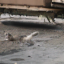

In [23]:
# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, op['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens = th.tensor([tokens]*batch_size,device=device),
    mask=th.tensor([mask]*batch_size,dtype=th.bool,device=device),
)

#Setup guidance function for CLIP model
cond_fn = clip_model.cond_fn([prompt]*batch_size,guidance_scale)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model,
    (batch_size, 3, op["image_size"], op["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,  
    cond_fn=None,
)
model.del_cache()

# Show the output 
show_images(samples)

Upsample the 64x64 samples


In [ ]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, op1['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, op1["image_size"], op1["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device, 
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

  0%|          | 0/27 [00:00<?, ?it/s]